# Example Jupyter notebook to work with the data

# Read in and plot the Apollo 12 Grade B 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from obspy import Trace
import os
from pathlib import Path


Let's pick the first seismic event in the catalog and let's take a look at the absolute time data. The way we show it here is by using pandas `.iloc` and datetime `.strptime`. We are going to keep the format shown in the absolute time header, which is `'%Y-%m-%dT%H:%M:%S.%f'`

## Read the CSV file

We will now find the csv data file corresponding to that time and plot it!

In [2]:
from pathlib import Path

def get_csv_files(folder_path):
    # Using pathlib for more flexible file management
    folder_path = Path(folder_path)
    csv_files = list(folder_path.glob('*.csv'))
    return csv_files
    
csv_files=get_csv_files('C:/Users/mgil/Desktop/Nasa_space_apps/space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB')

## Repeating the loop for calculating success rate

In [3]:
csv_file=csv_files[44]
data_cat = pd.read_csv(csv_file)
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1973-08-08T00:00:18.557861,0.000000,-5.324975e-15
1,1973-08-08T00:00:18.708804,0.150943,-6.692782e-15
2,1973-08-08T00:00:18.859748,0.301887,-7.302275e-15
3,1973-08-08T00:00:19.010691,0.452830,-7.052499e-15
4,1973-08-08T00:00:19.161635,0.603774,-6.216345e-15
...,...,...,...
572277,1973-08-08T23:59:59.991823,86381.433962,1.665582e-16
572278,1973-08-09T00:00:00.142767,86381.584906,-9.882056e-16
572279,1973-08-09T00:00:00.293710,86381.735849,-1.448389e-15
572280,1973-08-09T00:00:00.444653,86381.886792,-1.771166e-15


Text(0.5, 1.0, 'C:\\Users\\mgil\\Desktop\\Nasa_space_apps\\space_apps_2024_seismic_detection\\data\\lunar\\test\\data\\S12_GradeB\\xa.s12.00.mhz.1973-08-08HR00_evid00437.csv')

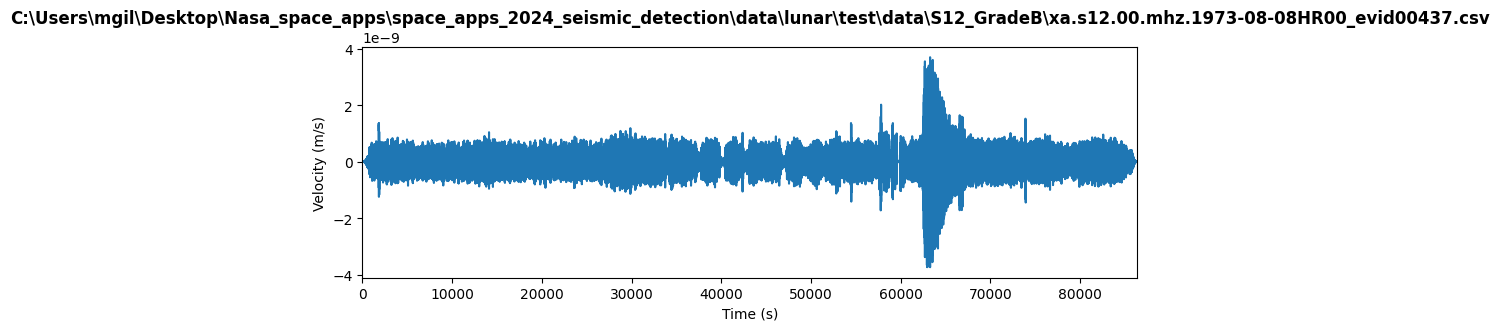

In [4]:
test_filename = csv_file

# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

## See the signal in the frequency spectrum and finding at which frequency corresponds the maximum magnitude

Number of samples: 572282
FFT computation completed.
Frequency bins computed.
Magnitude spectrum calculated and normalized.


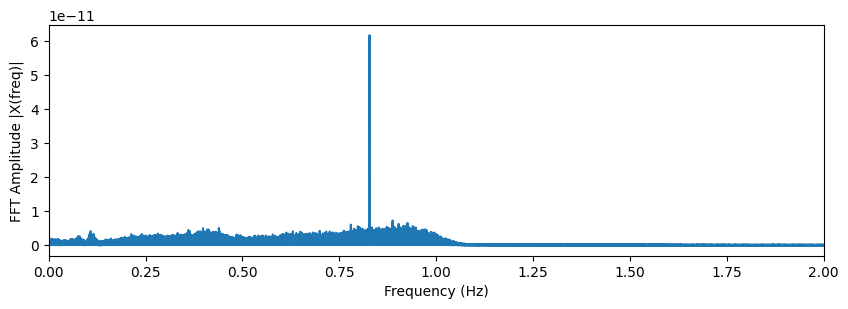

Maximum Magnitude: 6.171969247721405e-11
Maximum Frequency: 0.83 Hz
Frequency Window: [0.68 Hz, 0.98 Hz]


In [5]:
def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a band-pass filter to the data.

    Parameters:
    - data: NumPy array of seismic data.
    - lowcut: Low cutoff frequency in Hz.
    - highcut: High cutoff frequency in Hz.
    - fs: Sampling rate in Hz.
    - order: Order of the filter.

    Returns:
    - filtered_data: NumPy array of filtered data.
    """
    from scipy.signal import butter, filtfilt
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data



def compute_fft(signal, sampling_rate):
    """
    Compute the Fast Fourier Transform (FFT) of a signal and return the frequency and magnitude spectrum.

    Parameters:
    ----------
    signal : array_like
        The input time-domain signal (1D NumPy array).
    sampling_rate : float
        The sampling rate of the signal in Hertz (Hz).

    Returns:
    -------
    freqs : numpy.ndarray
        Array of frequency bins corresponding to the FFT components.
    magnitude : numpy.ndarray
        Magnitude spectrum of the FFT.
    """
    # Number of samples in the signal
    N = len(signal)
    print(f"Number of samples: {N}")

    # Compute the FFT using NumPy's FFT function
    fft_vals = np.fft.fft(signal)
    print("FFT computation completed.")

    # Compute the corresponding frequencies
    freqs = np.fft.fftfreq(N, d=1/sampling_rate)
    print("Frequency bins computed.")

    # Only take the positive half of the spectrum (real signals are symmetric)
    positive_freqs = freqs[:N // 2]
    positive_fft = fft_vals[:N // 2]

    # Compute the magnitude spectrum and normalize
    magnitude = (2.0 / N) * np.abs(positive_fft)
    print("Magnitude spectrum calculated and normalized.")

    return positive_freqs, magnitude

N=len(csv_data);
fa=1/((csv_times[2]-csv_times[1]));
freqs,magnitude=compute_fft(csv_data,fa)
    
# Plot FFT
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(freqs, magnitude)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('FFT Amplitude |X(freq)|')
ax.set_xlim(0, 2)  # Adjust as needed

plt.show()
import numpy as np

# Step 1: Find the index of the maximum magnitude
max_magnitude = max(magnitude)
max_index = np.argmax(magnitude)

# Step 2: Get the frequency corresponding to the max magnitude
max_frequency = freqs[max_index]

# Step 3: Define the window around the max frequency (e.g., ±0.1 Hz)
freq_window_lower = max_frequency - 0.15
freq_window_upper = max_frequency + 0.15

print(f"Maximum Magnitude: {max_magnitude}")
print(f"Maximum Frequency: {max_frequency:.2f} Hz")
print(f"Frequency Window: [{freq_window_lower:.2f} Hz, {freq_window_upper:.2f} Hz]")




## Filtering the signal in the frequency using a band pass filter

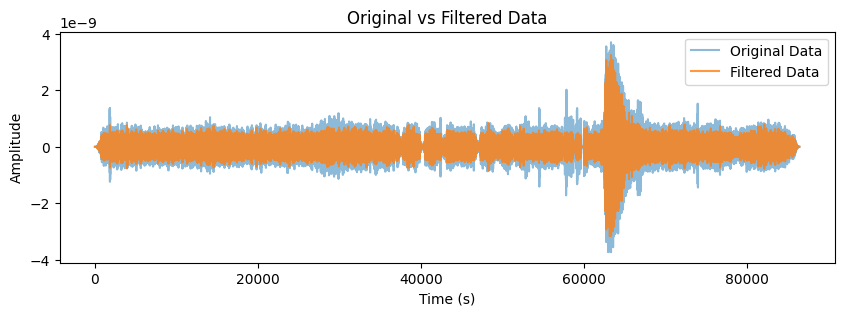

Number of samples: 572282
FFT computation completed.
Frequency bins computed.
Magnitude spectrum calculated and normalized.


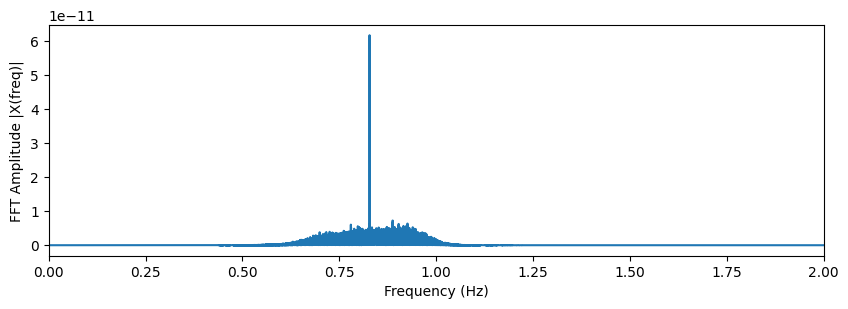

In [6]:
import pandas as pd
from obspy import Trace



# Step 2: Create Trace Object
delta_t = csv_times[1] - csv_times[0]
fa = 1.0 / delta_t
trace = Trace(data=csv_data)
trace.stats.sampling_rate = fa
        
# Apply the bandpass filter for each pair of a[i] and b[i]
trace_filtered = trace.filter('bandpass', freqmin=freq_window_lower, freqmax=freq_window_upper)

# Step 4: Access Filtered Data and Times
filtered_data = trace_filtered.data
filtered_times = csv_times

# Step 5: (Optional) Save to CSV
filtered_df = pd.DataFrame({'time': filtered_times, 'filtered_amplitude': filtered_data})
filtered_df.to_csv('filtered_seismic_data.csv', index=False)



# Step 6: (Optional) Plot the Data
import matplotlib.pyplot as plt
# Plot original data and filtered data
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(csv_times, csv_data, label='Original Data', alpha=0.5)
ax.plot(filtered_times, filtered_data, label='Filtered Data', alpha=0.8)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Original vs Filtered Data')
ax.legend()
plt.show()

freqs,magnitude=compute_fft(filtered_data,fa)
    
# Plot FFT
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(freqs, magnitude)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('FFT Amplitude |X(freq)|')
ax.set_xlim(0, 2)  # Adjust as needed

plt.show()



## The filtered signal in the time spectrum

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


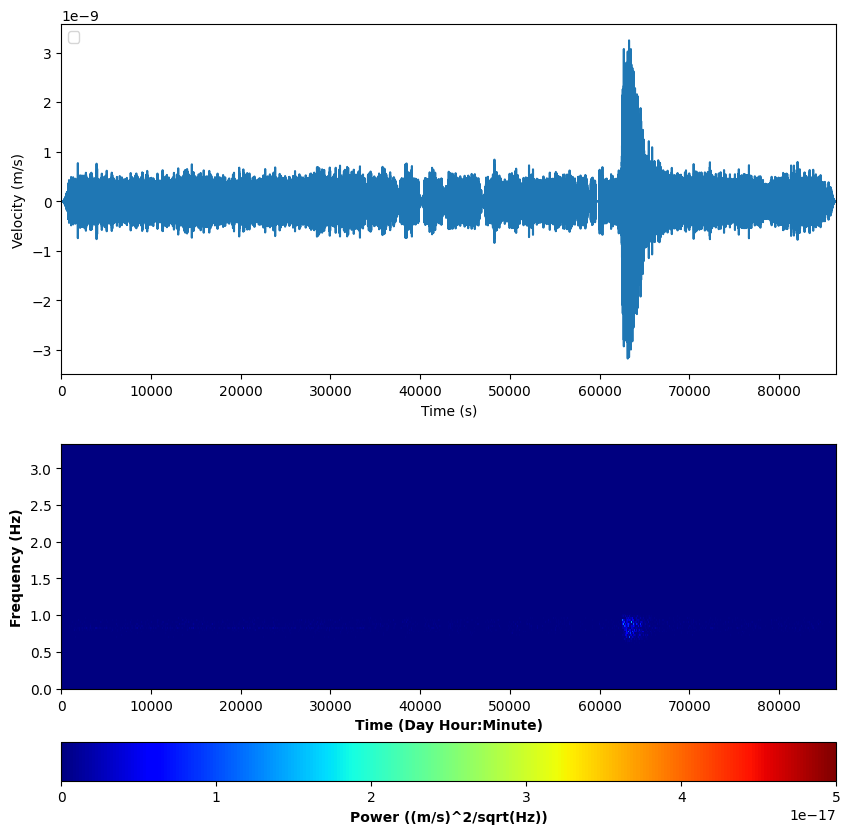

In [7]:
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(filtered_data, fa)

# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(csv_times,filtered_data)
# Mark detection
ax.legend(loc='upper left')
# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(csv_times),max(csv_times)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

## Normalização do sinal filtrado

Potencia do sinal 1.656282030237762e-07
Média do sinal normalizado ao quadrado é : 1.7473902726278215e-06


Text(0.5, 1.0, 'C:\\Users\\mgil\\Desktop\\Nasa_space_apps\\space_apps_2024_seismic_detection\\data\\lunar\\test\\data\\S12_GradeB\\xa.s12.00.mhz.1973-08-08HR00_evid00437.csv')

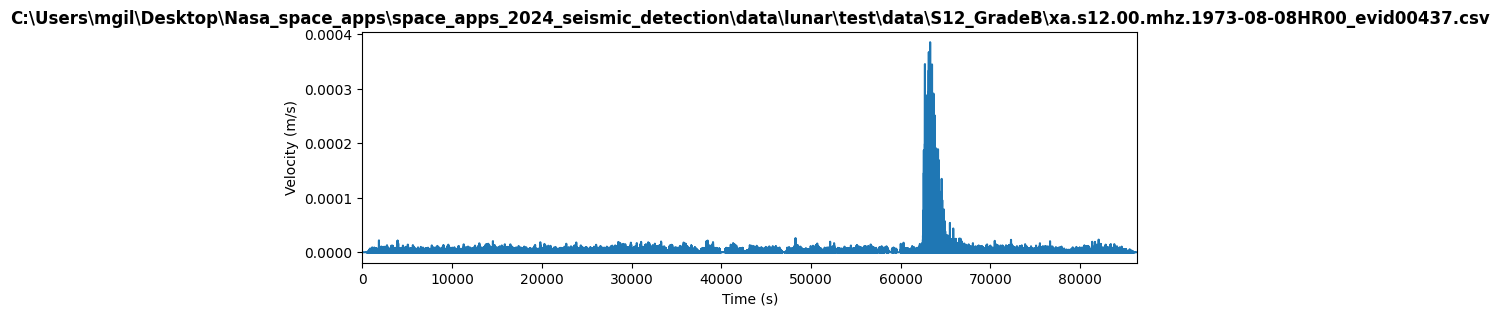

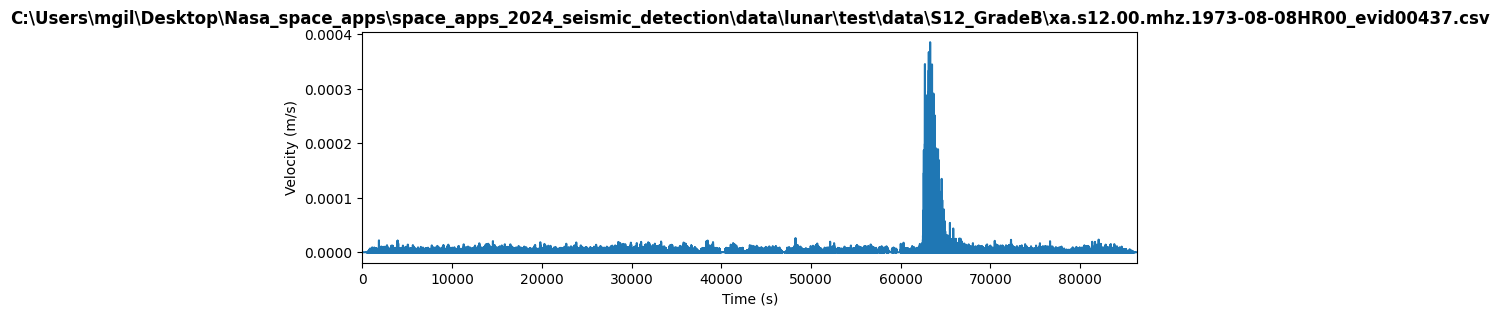

In [8]:
# Calculate the L2 norm (Euclidean norm) of the signal
Potencia = np.sqrt(np.sum(filtered_data**2))
filtered_data_normalizado=filtered_data/Potencia
print('Potencia do sinal',Potencia)
filtered_data_normalizado_sq=filtered_data_normalizado**2
# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(filtered_times,filtered_data_normalizado_sq)

# Make the plot pretty
ax.set_xlim([min(filtered_times),max(filtered_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{csv_file}', fontweight='bold')

Media_do_sinal=sum(filtered_data_normalizado_sq)/len(filtered_data_normalizado_sq)
print('Média do sinal normalizado ao quadrado é :',Media_do_sinal)

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(filtered_times,filtered_data_normalizado_sq)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold') 

## Algorithm for finding optimal treshold 

media é: 3.375636372045147e-06
Contagem em cada faixa: [53817, 2475, 1169, 637, 409, 289, 181, 123, 83, 62, 35, 27, 20, 16, 18, 6, 5, 3, 1, 2]
Contagem em cada faixa: [53817, 2475, 1169, 637, 409, 289, 181, 123, 83, 62, 35, 27, 20, 16, 18, 6, 5, 3, 1, 2]
[[62839.3962264151, 18], [63492.52830188679, 23], [63540.52830188679, 18]]
Média das posições: 63291


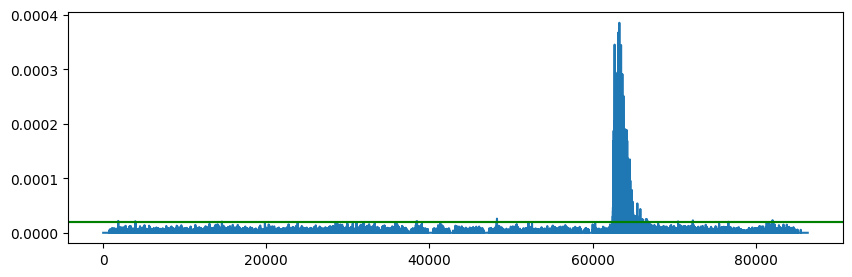

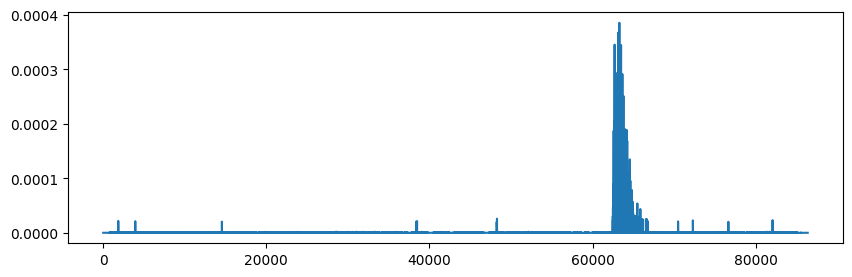

In [9]:
csv_data_normalizado_ao_quadrado=filtered_data_normalizado_sq.copy()

mediana= np.median (csv_data_normalizado_ao_quadrado)

media = 0
counter=0
mediana= np.median (csv_data_normalizado_ao_quadrado)
for i in range(1, len(csv_data_normalizado_ao_quadrado)):        
         if csv_data_normalizado_ao_quadrado[i] > mediana:
            media = media + csv_data_normalizado_ao_quadrado[i]
            counter= counter + 1
#print('V max é:', v_max)
print('media é:', media/counter)
for i in range(1, len(csv_data_normalizado_ao_quadrado)):        
         if csv_data_normalizado_ao_quadrado[i] < media/counter:
            csv_data_normalizado_ao_quadrado[i]=0

fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data_normalizado_ao_quadrado)

# Definindo o número de intervalos
num_intervals = 20

# Encontrar o valor máximo
v_max = 0
for i in range(1, len(csv_data_normalizado_ao_quadrado)):
    if csv_data_normalizado_ao_quadrado[i] > v_max:
        v_max = csv_data_normalizado_ao_quadrado[i]

# Calcular o espaço de cada faixa
space = (v_max - mediana) / num_intervals

# Inicializar a lista com zeros para os intervalos
place = [0] * num_intervals

# Loop sobre os dados normalizados ao quadrado para contar em cada intervalo
for i in range(1, len(csv_data_normalizado_ao_quadrado)):
    # Verifica em qual faixa a amostra se encontra
    for j in range(num_intervals):
        lower_bound = mediana + j * space
        upper_bound = mediana + (j + 1) * space
        if lower_bound < csv_data_normalizado_ao_quadrado[i] <= upper_bound:
            place[j] += 1
            break  # Para evitar contar duas vezes

# Exibir os resultados
print("Contagem em cada faixa:", place)
arrival_line = ax.axhline(y=mediana + space, c='green', label='Rel. Arrival')

max_valor = max(place)  # Encontrar o maior valor
max_indice = place.index(max_valor)  # Encontrar o índice do maior valor
media_media = mediana + (1 + max_indice) * space
# Exibir os resultados
print("Contagem em cada faixa:", place)
arrival_line = ax.axhline(y=mediana + space, c='green', label='Rel. Arrival')


max_valor = max(place)  # Encontrar o maior valor
max_indice = place.index(max_valor)  # Encontrar o índice do maior valor
media_media = mediana + (1+ max_indice)*space

signal_fn = [] 
for i in range(1, len(csv_data_normalizado_ao_quadrado)):        
         if csv_data_normalizado_ao_quadrado[i] < media_media:
            csv_data_normalizado_ao_quadrado[i]*=0.1
signal_fn = csv_data_normalizado_ao_quadrado.copy()
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data_normalizado_ao_quadrado)

position = 0
times = 0
contador = 0
trigger = 0
array = []
k = 64

# Loop until the array is not empty
while len(array) == 0:
    for i in range(1, len(csv_data_normalizado_ao_quadrado)):        
        if csv_data_normalizado_ao_quadrado[i] > media_media:
            contador += 1
            trigger = 1
            if contador > k:
                position = csv_times[i - k]  # Get the position at i - k

        if csv_data_normalizado_ao_quadrado[i] < media_media:
            if trigger == 1 and contador > k:
                times = contador
                array.append([position, times])  # Append position and times to array
            contador = 0
            trigger = 0

    # If array is still empty after the loop, reduce k by half
    if len(array) == 0:
        k = k // 2  # Divide k by 2

# Output the result
print(array)

# Calculate the average of the positions
positions = [item[0] for item in array]  # Extracting positions
media_positions = round(np.mean(positions))  # Calculate the mean of positions

# Print the average positions
print(f'Média das posições: {media_positions}')


## Filtered signal after data analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


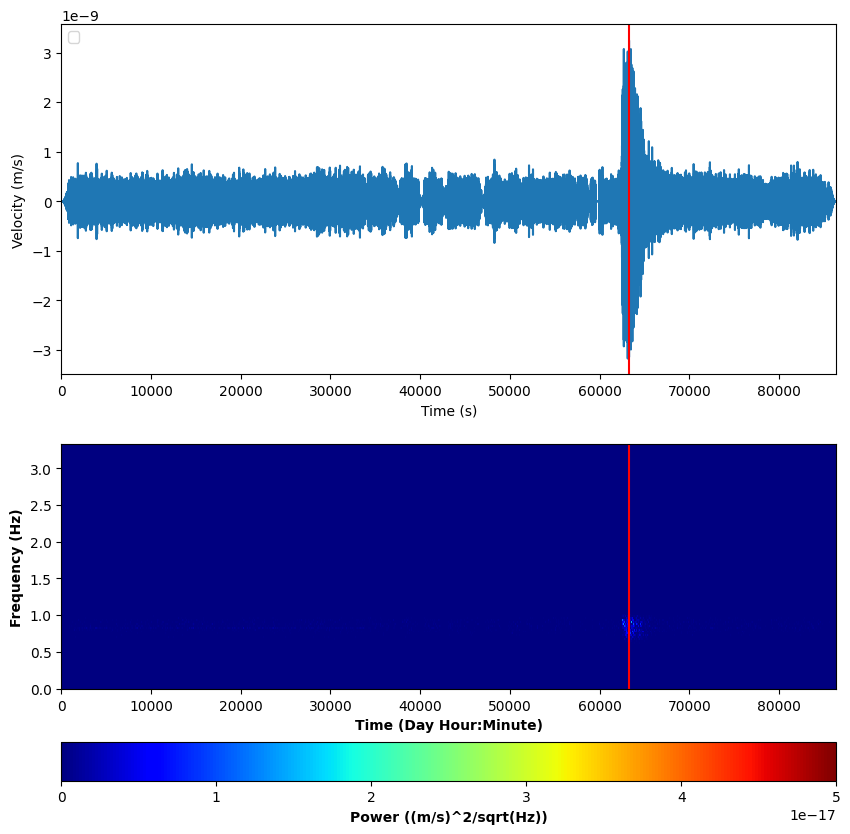

In [10]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(csv_times,filtered_data)
# Mark detection
ax.legend(loc='upper left')
# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.axvline(x=media_positions, c='red')
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(csv_times),max(csv_times)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=media_positions, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')